# Applied Machine learning !

In this lab we will study a soccer dataset and apply Machine Learning to it. We will try to predict the skin color of a player given some of it's information

### Some useful imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

### First we import the dataset and study it :

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

How much data do we have ?

In [3]:
df.shape

(146028, 28)

Let's look at our columns

In [4]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
df.head().ix[:10,0:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
df.head().ix[:10,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [6]:
df[df.rater1 == df.rater2].shape

(95714, 28)

In [7]:
df["rater2"].unique()

array([ 0.5 ,  0.75,   nan,  0.  ,  0.25,  1.  ])

Thanks to the previous work of Mat Evans and Tom Stafford and their team (can be found here : http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb )

we know some of the specificities of the data :

- We learn that the data is organized in a player-referee dyad. This means each row has all the interaction with one player and a referee. For their analysis they decided to separate this dataset for each interaction between a player and a referee. For our purposes we will rather group by player short because we don't really care for referee information.

- The data about skin color is not consistent between the two raters and the picture is missing. For the picture we will just remove the data with no picture. As we need a way to attribute skin color to each player we will have to use the two raters. For this there are different ways we could go at it :
    - We could do a mean of the two raters
    - We could keep only the dyads which have the same score for r1 and r2
    - We could train on both raters and compare the result (seems a bit repetitive but why not)
    
- The raters data in the set [0, 0.25, 0.50, 0.75, 1] to classify "correctly" there are 3 possibilities :
    - The first one is to have a class for each number
    - The second is to have two classes with a cut at 0.5 (we have to define which class contain 0.5)
    - The third is to have 3 classes : $<0.5$, $0.5$, $>0.5$

- Finally we learn that there are dyads which are not really part of the 2012-2013 data but from past matches in the carrer of the player. Here we have a choice, either we remove the data because it's not really part of the dataset or we let it be as it could be more information.

Here is how we think of organizing this homework :
- First we will clean a bit the data
- Then we will aggregate the data per player
- Then we will for each point made above with multiple proposition see which one is the best, if multiple ones seem good we will keep them and test them with cross validation.
- Finally we will find the best result we can with all possible datasets with a random forest classifier.

## Removing non valid dyads from player past history

For a more detailed explanation of how we can show the fact that there are dyads from before 2012-2013 you can look here : http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb

To remove those dyad, the logic is to say that if a referee has participated in at least one match in the league he should have at least 22 appearances in the dataset.

The folowing code ressembles (as we use the same principles) the work previously mentioned. But as we will see some differences I will try and explain them as we go through the code to show we aren't doing anything wrong.

In [8]:
referee_b = df["refNum"].unique().shape[0]
print("number of unique referee before cleaning : ", referee_b) # here no differences

number of unique referee before cleaning :  3147


In [9]:
dyads_b = df.shape[0]
games_b = df.games.sum()
print("number of dyads before cleaning : ", dyads_b)
print("number of matches before cleaning : ", games_b) # same value as in the other notebook 
                                                     # (we will use it later as reference)

number of dyads before cleaning :  146028
number of matches before cleaning :  426572


This part shows the value that the others get :

In [10]:
apearances_tot = df[["refNum", "games"]].groupby("refNum").sum()

In [11]:
apearances_sup21_tot = apearances_tot[apearances_tot.games > 21]
apearances_sup21_tot.count() # same number of remaining referee as in the other notebook

games    1261
dtype: int64

In [12]:
df_sup21_tot = df[df["refNum"].isin(apearances_sup21_tot.index)]

In [13]:
referee_a_tot = df_sup21_tot["refNum"].unique().shape[0]
print("number of unique referee after removing : ", referee_a_tot)

number of unique referee after removing :  1261


In [14]:
dyads_a_tot = df_sup21_tot.shape[0]
games_a_tot = df_sup21_tot.games.sum()
print("number of dyads after removing : ", dyads_a_tot)
print("number of matches after removing : ", games_a_tot) # same number as in the other notebook 

number of dyads after removing :  137635
number of matches after removing :  415692


Now as our data is organized differently we use another method

Here is what will change most of the calculations result

In [15]:
apearances_once_player = df.refNum.value_counts()
len(apearances_once_player)

3147

This is the number of apearances with a slight twist, we only count one apearance per player whatever the number of match he played. For us this value is better to use in this case as it relates more to the >21 cut. Before we counted for a single referee a number of matches with the same player which makes no sense : in a match, a referee has 22 distinct players.

In [16]:
apearances_sup21_once_player = apearances_once_player[apearances_once_player > 21]
len(apearances_sup21_once_player) ## a bit less than before sadly

998

In [17]:
df_sup21_once_player = df[df["refNum"].isin(apearances_sup21_once_player.index.values)]

In [18]:
referee_a_once_player = df_sup21_once_player["refNum"].unique().shape[0]
print("number of unique referee after removing : ", referee_a_once_player)

number of unique referee after removing :  998


In [19]:
dyads_a_once_player = df_sup21_once_player.shape[0]
games_a_once_player = df_sup21_once_player.games.sum()
print("number of dyads after removing : ", dyads_a_once_player)
print("number of matches after removing : ", games_a_once_player) # a bit lower than before again

number of dyads after removing :  133501
number of matches after removing :  406924


Let's show how much data we lose

In [20]:
print("loss of games with their method :", games_a_tot / games_b)
print("loss of dyads with their method :", dyads_a_tot / dyads_b)
print("loss of refs with their method : ", referee_a_tot / referee_b)


loss of games with their method : 0.974494340932
loss of dyads with their method : 0.9425247212863287
loss of refs with their method :  0.40069907848744835


In [21]:
print("loss of games with our method :", games_a_once_player / games_b)
print("loss of dyads with our method :", dyads_a_once_player / dyads_b)
print("loss of refs with our method : ", referee_a_once_player / referee_b)

loss of games with our method : 0.953939780389
loss of dyads with our method : 0.914215082039061
loss of refs with our method :  0.3171274229424849


### Here we show some graphes to show the difference between the two methods.

Graph of occurences (source from http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)

We thought of using their graphs to have a good comparaison between their work and ours

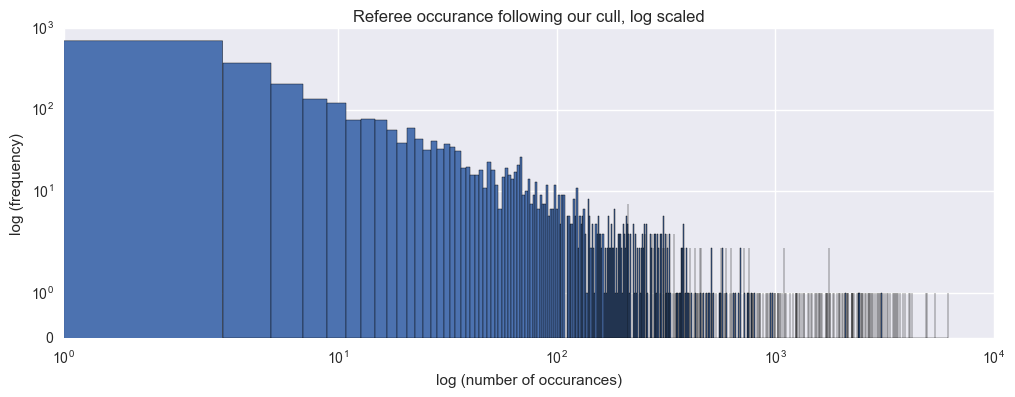

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

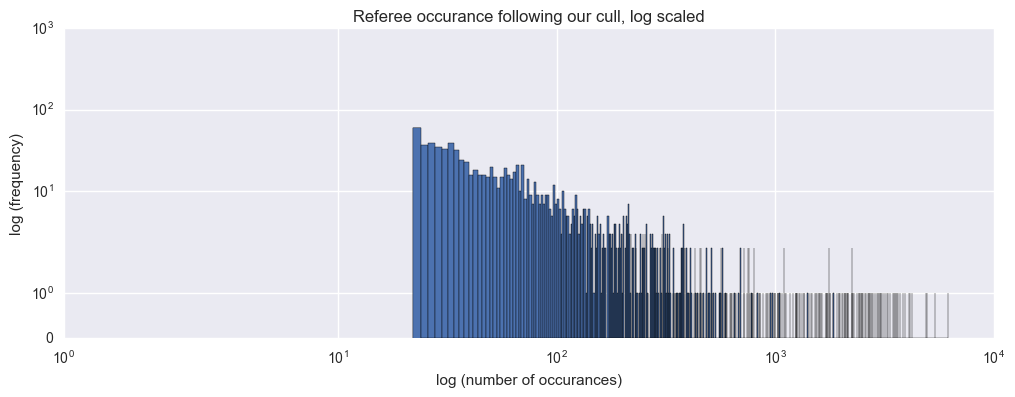

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df_sup21_tot[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

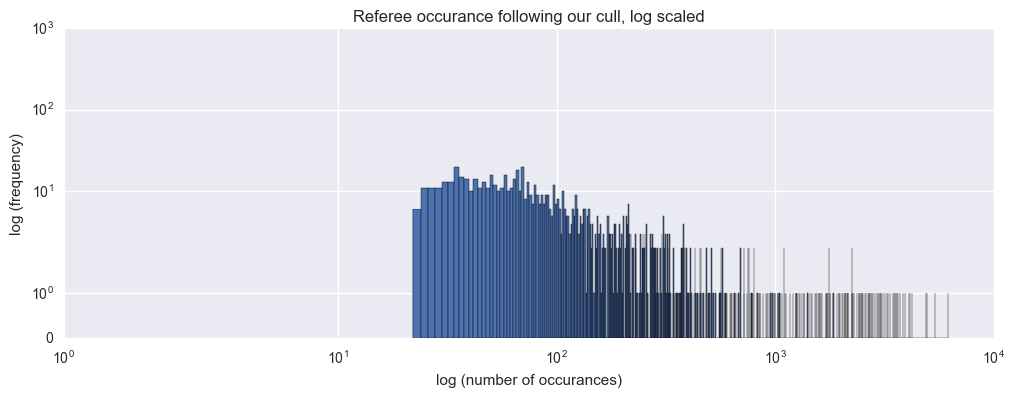

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df_sup21_once_player[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

We can clearly see here that we only remove the lowest occurences of the previous graph

(-3, 160)

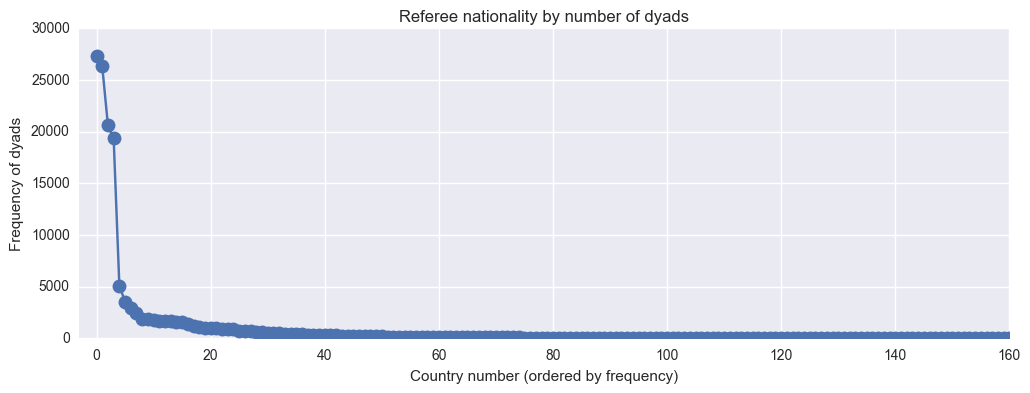

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist() 

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

(-3, 160)

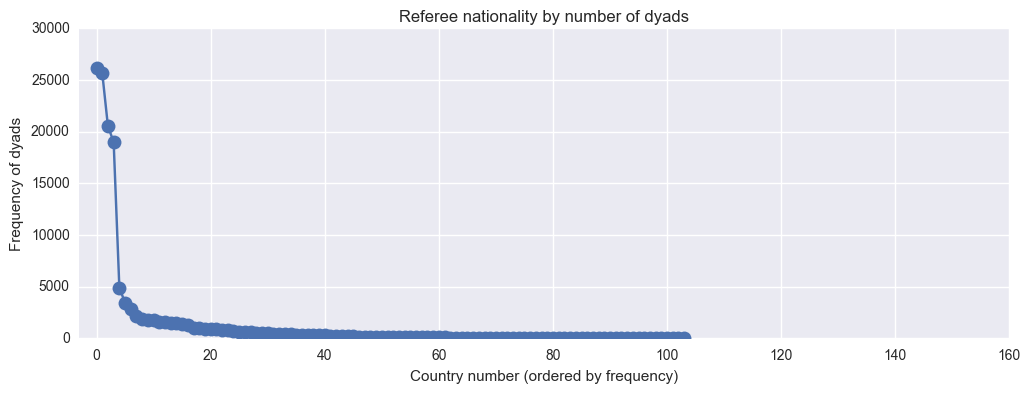

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df_sup21_tot.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist() 

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

(-3, 160)

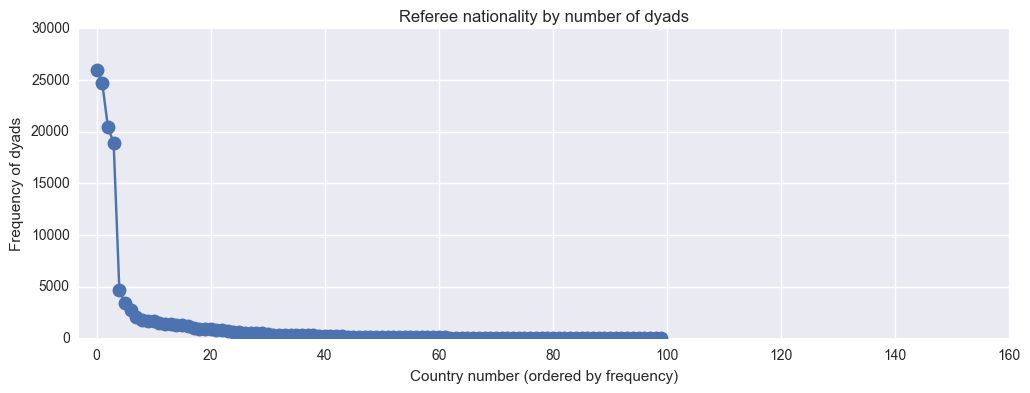

In [27]:
# Histogram of country frequency. 
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df_sup21_once_player.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist()

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

Here we see that our method reduces the number of total countries but doesn't change the frequency of dyads with the most represented countries compared to the previous graph

## Removing non usable data for our ML algorithm

We know sometimes there is no images for a player and therefor no skin color rating. Therefore we remove them.

In [28]:
df_with_pic = df_sup21_once_player[df_sup21_once_player["photoID"].notnull()]

In [29]:
df_sup21_once_player.shape[0]

133501

In [30]:
df_with_pic.shape[0]

113862

Should be all clean now.

In [31]:
dfc = df_with_pic

## Aggregating the data by player

Let's look at a single players dyad to have an idea of what it looks like

In [32]:
groups = dfc.groupby("playerShort")

In [33]:
lucas = groups.get_group("lucas-wilchez")

In [34]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
lucas.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
2782,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,3,1,1,1,0
3384,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
5692,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,1,0,0,0
9058,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,2,2,0,0,0
14886,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,1,0,0


In [35]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
lucas.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
2782,0,0,0,95212.jpg,0.25,0.5,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3384,0,0,0,95212.jpg,0.25,0.5,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5692,0,0,0,95212.jpg,0.25,0.5,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
9058,1,0,0,95212.jpg,0.25,0.5,214,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
14886,0,0,0,95212.jpg,0.25,0.5,313,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696


First we will only keep the columns that seem relevant to us and remove the ones we think are not important :
- player name which is a repetition of the playershort
- birthday as it should not be relevant, completely independent (that would be weird al least :))
- refNum, refCountry, Alpha3 which are not easily usable as an aggregated feature (a solution to use this part of the data will be detailed later)
- nIAT and nExp really not relevant here 
    we could do a weihted mean with the "mean" and "se" columns but it seemed a bit exagerated (could be a futur improvement ?)
    
Why we kept other columns is explained below with the aggregation operation.

In [36]:
# We only keep what we think are relevant columns.
df_filtered = dfc[["playerShort","club", "leagueCountry", "height", "weight", "position", "games", "victories", 
                 "ties", "defeats", "goals", "yellowCards", "yellowReds", "redCards",
                 "rater1", "rater2", "meanIAT", "seIAT", "meanExp", "seExp"]]

In [37]:
df_grouped = df_filtered.groupby("playerShort").agg({
        "club": lambda x: x.unique()[0],
        "leagueCountry": lambda x: x.unique()[0],
        "height": np.max,
        "weight": np.max,
        "position": lambda x: x.unique()[0],
        "games": np.sum,
        "victories": np.sum,
        "ties": np.sum,
        "defeats": np.sum,
        "goals": np.sum,
        "yellowCards": np.sum,
        "yellowReds": np.sum,
        "redCards": np.sum,
        "rater1": np.max, # never changes so we can take either min, max or mean 
        "rater2": np.max, # same here (we used this to test that nothing changed : [np.min, np.max, np,mean])
        "meanIAT": np.mean, # Here doing the mean seems a bit confusing but it will give an 
        "seIAT": np.mean,   # indicatiion whether the player could have been mistreated in 
                            # some of his matches or never.
        "meanExp": np.mean, # Same here
        "seExp": np.mean    # We could have applied pooled variance (will see later) : https://en.wikipedia.org/wiki/Pooled_variance
    })

In [38]:
# We used this to check wether min and max rating change for each player (which was not the case)
#df_grouped[df_grouped["rater1", "amin"] != df_grouped["rater1", "amax"]]

In [39]:
# We used this to test if some players had multiple clubs, league country or position. Which was not the case.
#print(df_grouped["club"].apply(lambda x: x[0].shape).unique())
#print(df_grouped["leagueCountry"].apply(lambda x: x[0].shape).unique())
#print(df_grouped["position"].apply(lambda x: x[0].shape).unique())

In [40]:
df_grouped.head()

,yellowReds,meanIAT,weight,rater2,yellowCards,goals,seExp,leagueCountry,meanExp,club,games,position,ties,seIAT,victories,height,rater1,defeats,redCards
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,0.344759,71.0,0.00,19,9,0.001553,England,0.487879,Fulham FC,641,Center Back,176,0.000333,243,182.0,0.25,222,0
aaron-hunt,0,0.349332,73.0,0.25,39,59,0.001025,Germany,0.453989,Werder Bremen,329,Attacking Midfielder,70,0.000226,140,183.0,0.00,119,1
aaron-lennon,0,0.345893,63.0,0.25,11,31,0.002032,England,0.491482,Tottenham Hotspur,412,Right Midfielder,97,0.000367,200,165.0,0.25,115,0
aaron-ramsey,0,0.346790,76.0,0.00,31,39,0.002938,England,0.511650,Arsenal FC,254,Center Midfielder,42,0.000525,145,178.0,0.00,67,1
abdelhamid-el-kaoutari,4,0.331600,73.0,0.25,8,1,0.005296,France,0.335587,Montpellier HSC,124,Center Back,40,0.001488,41,180.0,0.25,43,2


In [41]:
len(df_grouped)

1584

Thanks to the description of the data in DATA.md we know there should be 1586 players with pictures.
With this value we can validate the fact that we lost minimal data and have most of the players with a picture.

## Preparing Data

As a last step before starting to do machine learning we need to reformat the data and seperate it

First we need to make rows which contain strings in integers (club, position, leagueCountry)

In [42]:
from sklearn import preprocessing

df_grouped["club"] = df_grouped["club"].astype(np.str)
df_grouped["position"] = df_grouped["position"].astype(np.str)
df_grouped["leagueCountry"] = df_grouped["leagueCountry"].astype(np.str)

def encodeLabels(col, df):
    le = preprocessing.LabelEncoder()
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

encodeLabels("club", df_grouped)
encodeLabels("position", df_grouped)
encodeLabels("leagueCountry", df_grouped)

Now we can create the futur x and y for training

In [43]:
y_possible = df_grouped[["rater1","rater2"]]
y_possible.head()

,rater1,rater2
playerShort,,
aaron-hughes,0.25,0.00
aaron-hunt,0.00,0.25
aaron-lennon,0.25,0.25
aaron-ramsey,0.00,0.00
abdelhamid-el-kaoutari,0.25,0.25


Let's build y (in a naive fashion for now)

In [44]:
y = ((y_possible['rater1'] + y_possible['rater2']) / 2 < 0.5).values

In [45]:
x = df_grouped.drop(y_possible, axis=1)
x.head()

,yellowReds,meanIAT,weight,yellowCards,goals,seExp,leagueCountry,meanExp,club,games,position,ties,seIAT,victories,height,defeats,redCards
playerShort,,,,,,,,,,,,,,,,,
aaron-hughes,0,0.344759,71.0,19,9,0.001553,0,0.487879,34,641,1,176,0.000333,243,182.0,222,0
aaron-hunt,0,0.349332,73.0,39,59,0.001025,2,0.453989,90,329,0,70,0.000226,140,183.0,119,1
aaron-lennon,0,0.345893,63.0,11,31,0.002032,0,0.491482,82,412,10,97,0.000367,200,165.0,115,0
aaron-ramsey,0,0.346790,76.0,31,39,0.002938,0,0.511650,6,254,3,42,0.000525,145,178.0,67,1
abdelhamid-el-kaoutari,4,0.331600,73.0,8,1,0.005296,1,0.335587,51,124,1,40,0.001488,41,180.0,43,2


In [46]:
def prepFeature(feature) :
    nans = True in x[feature].isnull().unique()
    
    if nans:
        print("mean replacement of nans")
        x[feature] = x[feature].fillna(int(x[feature].mean()))
    
    f, ax = plt.subplots(1, 1)
    ax.set_title("histogram of feature " + feature)
    ax.hist(x[feature].values)

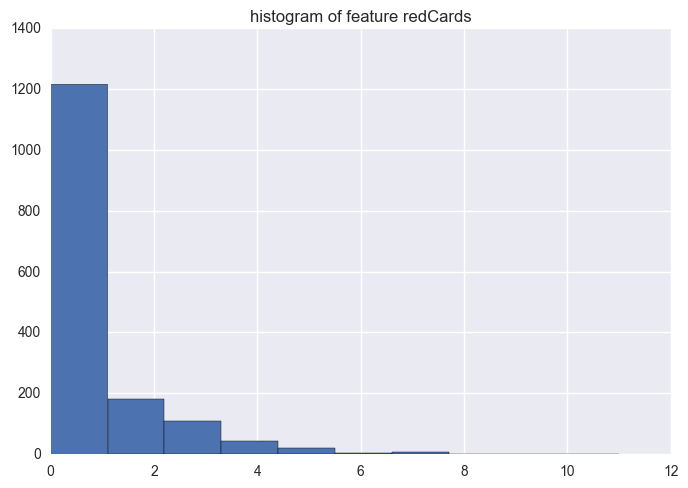

In [47]:
prepFeature("redCards")

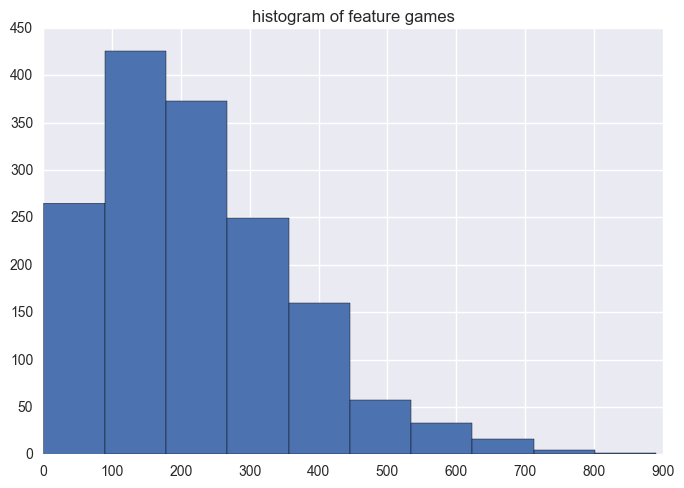

In [48]:
prepFeature("games")

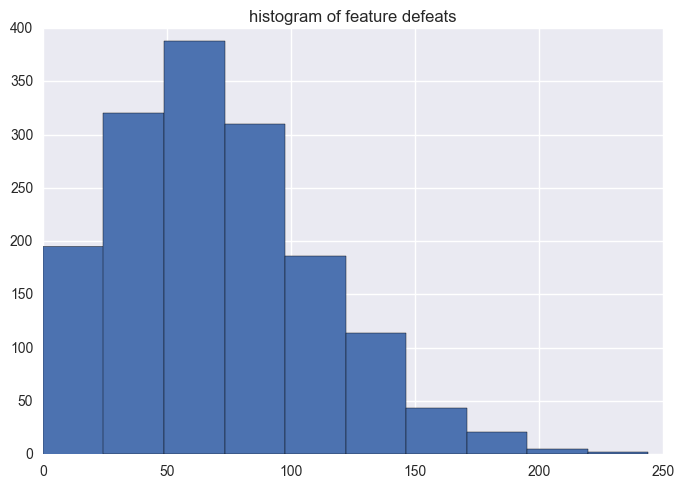

In [49]:
prepFeature("defeats")

mean replacement of nans


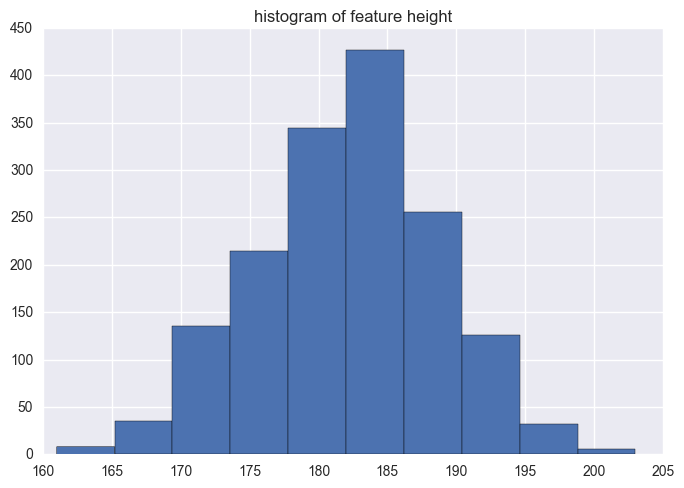

In [50]:
prepFeature("height")

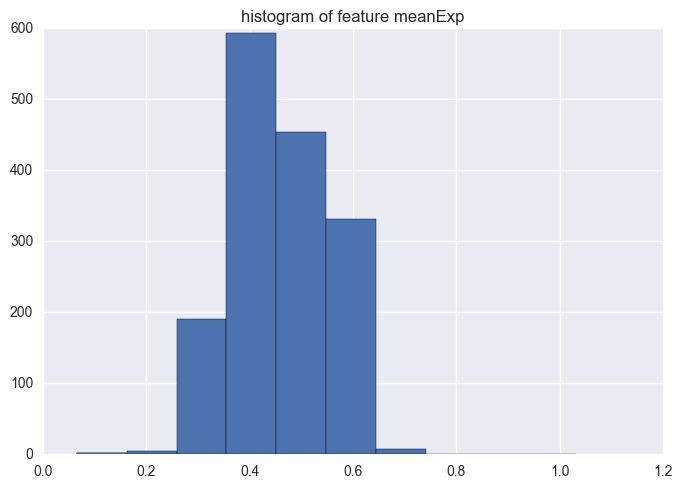

In [51]:
prepFeature("meanExp")

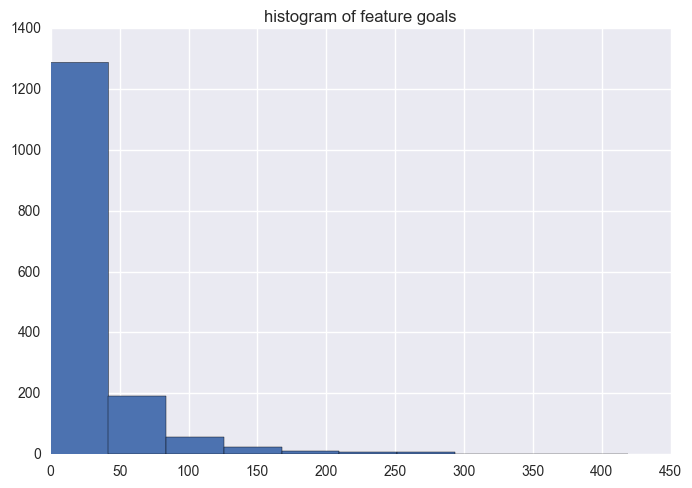

In [52]:
prepFeature("goals")

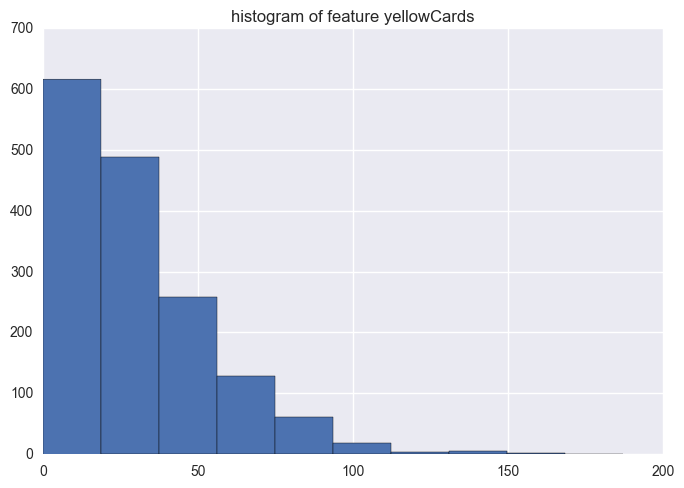

In [53]:
prepFeature("yellowCards")

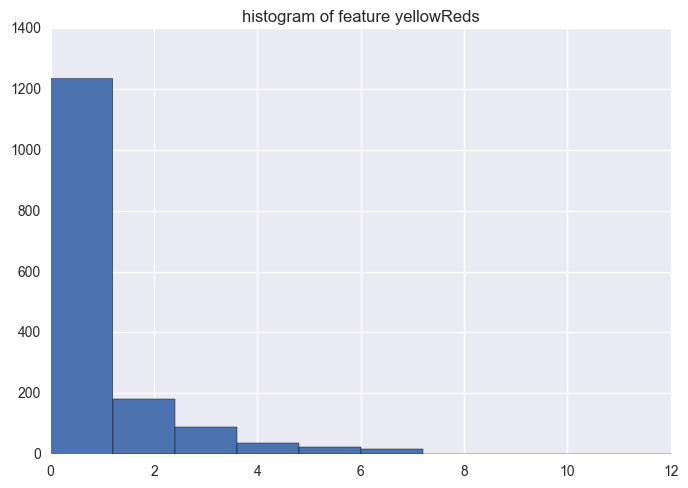

In [54]:
prepFeature("yellowReds")

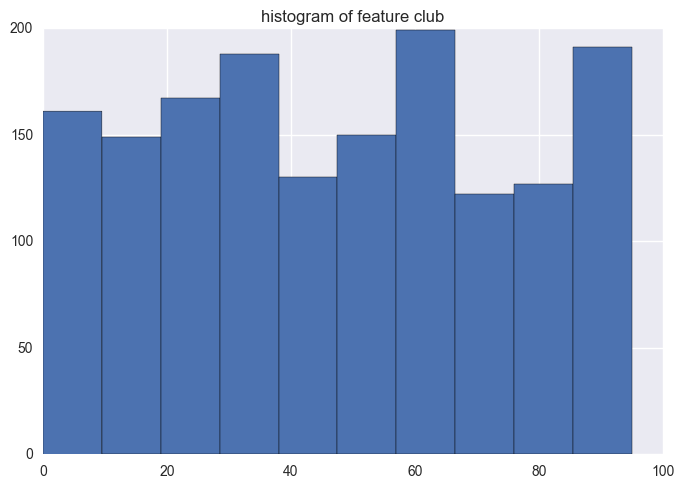

In [55]:
prepFeature("club")

mean replacement of nans


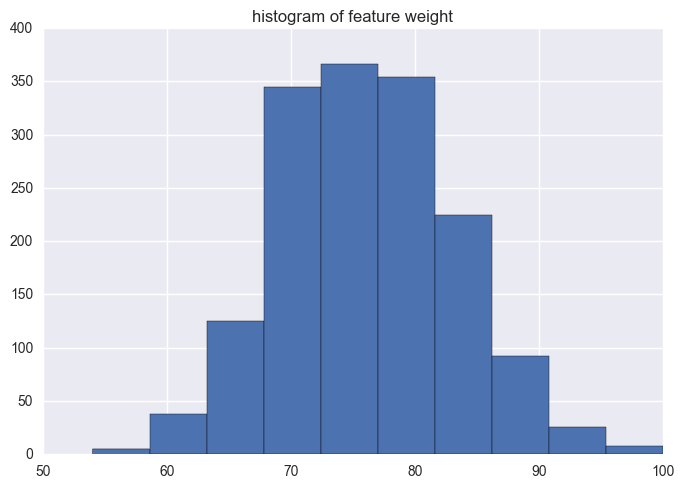

In [56]:
prepFeature("weight")

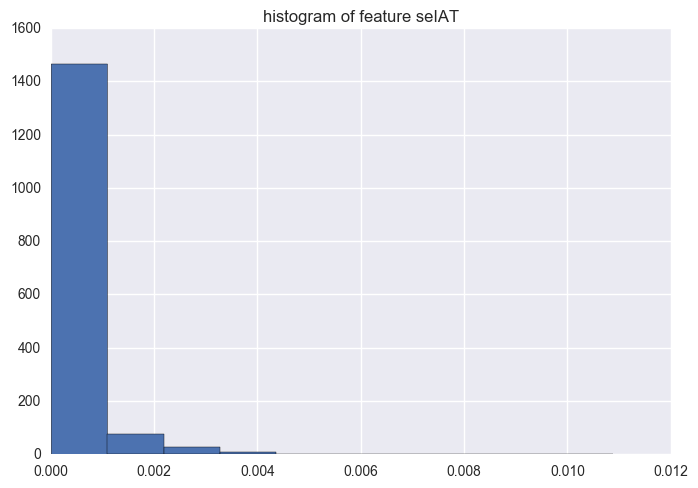

In [57]:
prepFeature("seIAT")

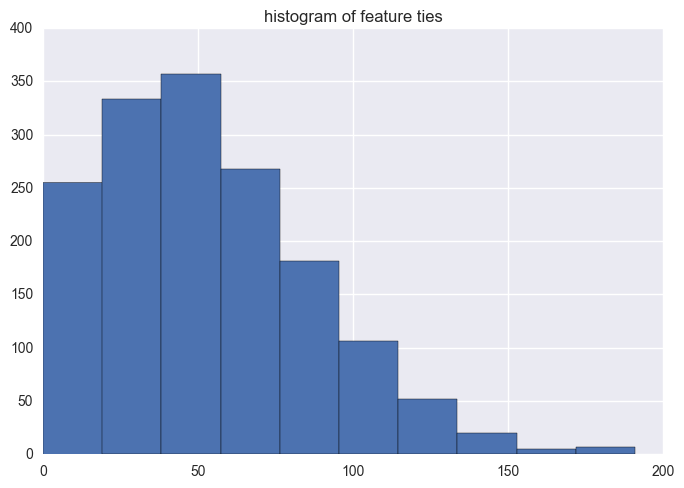

In [58]:
prepFeature("ties")

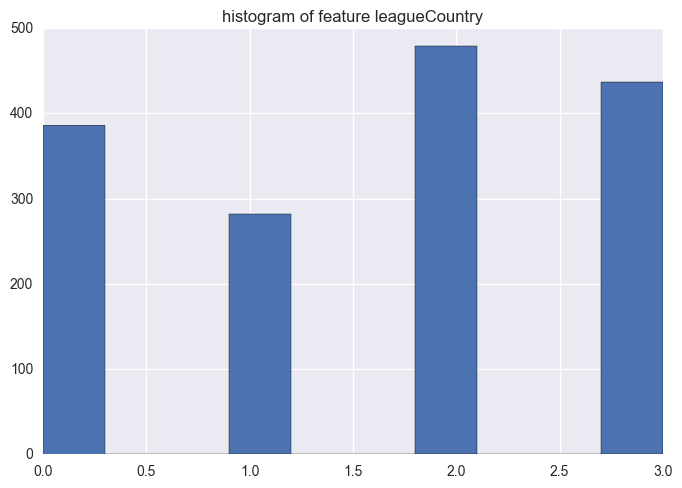

In [59]:
prepFeature("leagueCountry")

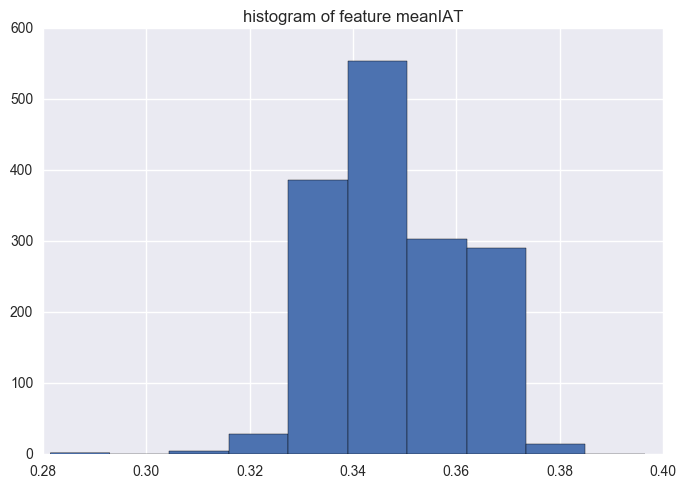

In [60]:
prepFeature("meanIAT")

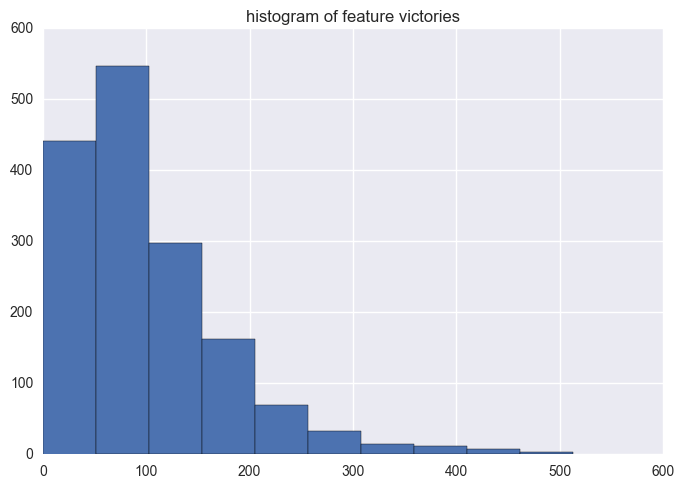

In [61]:
prepFeature("victories")

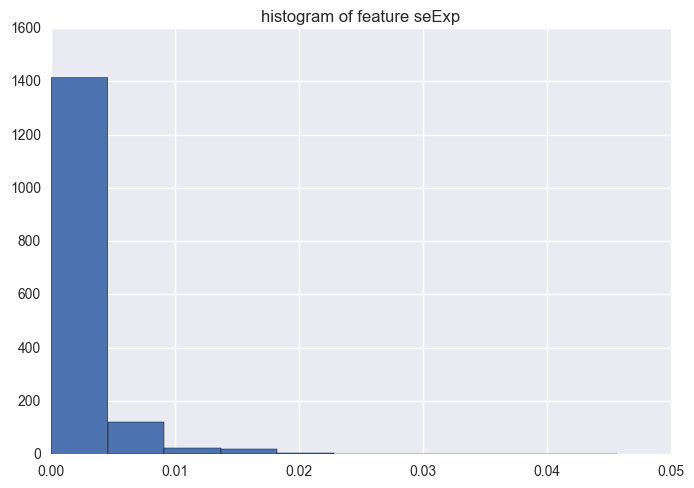

In [62]:
prepFeature("seExp")

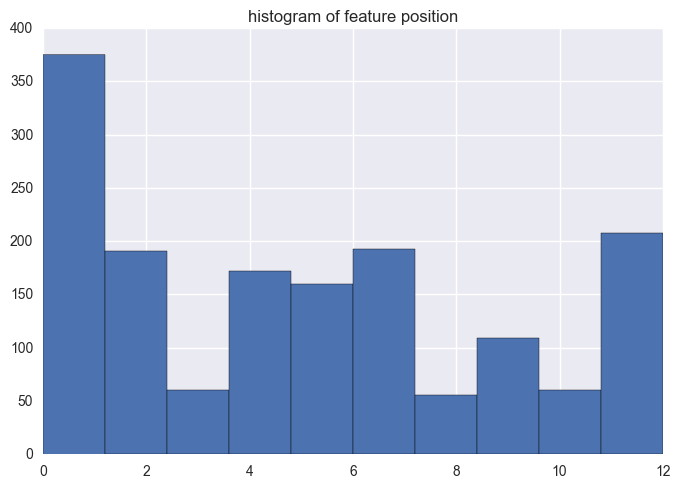

In [63]:
prepFeature("position")

In [65]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
new_x = normalizer.fit_transform(x, y)

In [66]:
new_x.shape

(1584, 17)

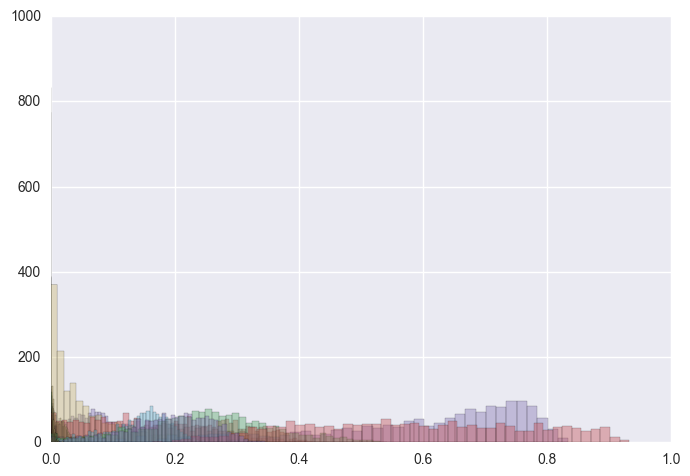

In [75]:
for feature in new_x.T:
    plt.hist(feature, alpha=0.4, bins=50)
    plt.show

In [84]:
x = new_x

## Naive machine learning

In [91]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics

In [92]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

In [96]:
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [97]:
y_pred = rfc.predict(x)

In [98]:
print(metrics.mean_absolute_error(y, y_pred))
print(metrics.accuracy_score(y, y_pred))

0.00694444444444
0.993055555556


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


### Ok so we're done here ! 99% seems reasonable, goodbye !

 ...

 ...

 ...

 ...

## Ok just kidding let's get serious with this !

First let's really test the naive approach and see how it could perform in a "real" situation.

let's first split the dataset into a training and testing set. This seems to be generally a good practice in machine learning :).

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [100]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

In [101]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [102]:
y_pred = rfc.predict(x_test)

In [103]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.239747634069
0.760252365931


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Ok that's kind of disapointing... (but not so much suprising). A better way to show the error is cross validation.

In [104]:
#rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

In [105]:
# Cross validation 10-Fold (for now) with accuracy scoring
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')

In [106]:
def show_score(scores):
    print(scores)
    print("--------------------------")
    print("mean :", np.mean(scores))
    print("min :", np.min(scores))
    print("max :", np.max(scores))

show_score(scores)

[ 0.71698113  0.75471698  0.72327044  0.67295597  0.76100629  0.73417722
  0.7721519   0.78481013  0.79746835  0.73248408]
--------------------------
mean : 0.745002248898
min : 0.672955974843
max : 0.79746835443


We can see again that the result is not pretty, the mean result we have is ~76% which is not much better than perdicting that all players are light skinned

proportions of classes for the mean rating (considering 1 -> $mean \leq 0.5$)

In [108]:
# Proportion of light and dark skinned players
prop_1 = np.sum(y) / len(y)
prop_0 = 1 - prop_1
print("proportion of ones :", prop_1)
print("proportion of zeroes :", prop_0)

proportion of ones : 0.756944444444
proportion of zeroes : 0.243055555556


Let's try to use some well known ML methods to understand what's going wrong.

Let's look at what the confusion matrix has to say.

In [109]:
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
TP = confusion_mx[1, 1]
TN = confusion_mx[0, 0]
FP = confusion_mx[0, 1]
FN = confusion_mx[1, 0]

In [110]:
confusion_mx

array([[ 24,  52],
       [ 24, 217]])

|total : 317| pred : 0 |  pred : 1  |
|---|----|-----|
| actual : 0 | TN = ~30 | FP = ~50 |
| actual : 1 | FN = ~30 | TP = ~200 |

We can see here that we are good at predicting ones, but our predictions of 0 are all over the place.

There is an easy way to show this : the **Specificity** (or how correct is the classifier with 0 values)

In [111]:
specificity = TN / float(TN + FP)
print("Specificity :", specificity)

Specificity : 0.315789473684


We can compare it to **Sensitivity** (or true positive rate)

In [112]:
sensitivity = TP / float(TP + FN)
print("sensitivity :", sensitivity)

sensitivity : 0.900414937759


Which is much better. 

PS : all these methods are taken from the course and the code was copied from this notebook :

http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

So, how are we going to do a better job ?

The first thing we realize is that there is a way to indicate to the random forest classifier the fact that there is a disparity within the data.

In [113]:
class_weights = {
    1 : prop_1,
    0 : prop_0
}

In [116]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=class_weights)

We will use a function that prints out most of the information we used above to test our new rfc 

In [117]:
from helpers import test_rfc
test_rfc(rfc, x, y)

Cross validation scores
[ 0.76656151  0.7192429   0.75394322  0.77602524  0.74683544]
--------------------------
cross mean : 0.75252166274
cross min : 0.719242902208
cross max : 0.776025236593
----------
TP : 221
TN : 24
FP : 52
FN : 20
----------
specificity : 0.315789473684
sensitivity : 0.917012448133


Ok, to bad it's not better than before.

Let's try something else : changing the classification threshold

We think this will help the **specificity** get higher.

let's retrain our data with our new rfc (with weights)

In [118]:
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

getting the probability of ones of the classifier

In [119]:
y_pred_prob = rfc.predict_proba(x_test)[:, 1]

Separating the probability of true and false values

In [120]:
y_pred_prob1 = [x[1] for x in zip(y_test, y_pred_prob) if x[0]]
y_pred_prob0 = [x[1] for x in zip(y_test, y_pred_prob) if not x[0]]

The following graph was inspired by this video :

https://www.youtube.com/watch?v=OAl6eAyP-yo

It shows in blue the probability given to the true 0 values and in red the probability of true 1 values.

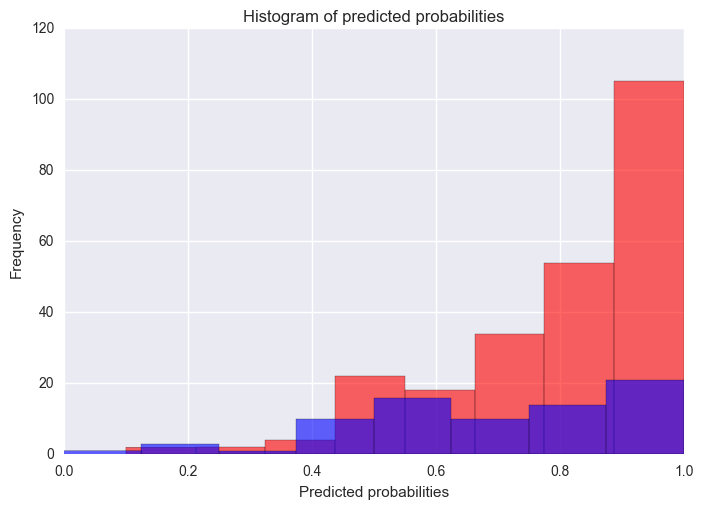

In [121]:
# histogram of predicted probabilities
plt.hist(y_pred_prob1, bins=8, alpha=0.6, color="red")
plt.hist(y_pred_prob0, bins=8, alpha=0.6, color="blue")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities')
plt.ylabel('Frequency')

With this graph we realized that it's going to be very difficult to have a good and fair (in terms of specificity and sensitivity) 

To verify this fact we are going to use the ROC curve and the AUC (Area Under the Curve) metric

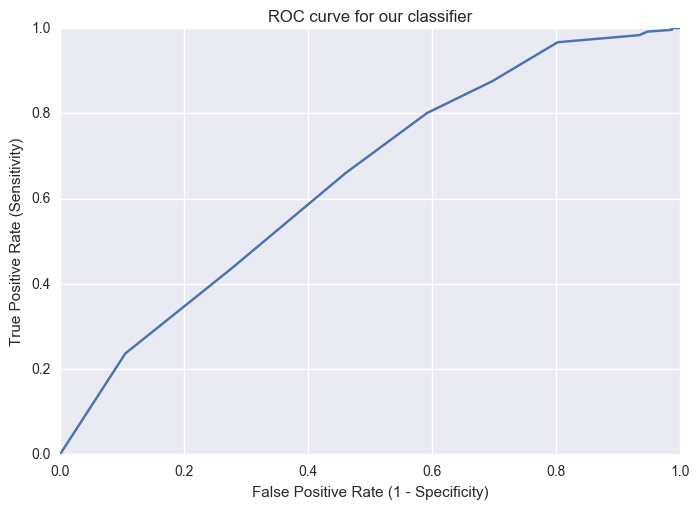

In [122]:
# Code copied entirely from 
# http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb
# There wasn't really another way to show that though :)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for our classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [123]:
# calculate cross-validated AUC score
AUC_mean = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc').mean()
print("AUC score :", AUC_mean)

AUC score : 0.671577645566


Ok, so what does this all mean.

First the ROC curve shows us what are the best compromises we can make between Specificity and Sensitivity (be aware that here specificity is inversed), with that you could chose precisely what you want the classifier to be compromising.

For the AUC score it shows a score of our model compared to a random sampling of 1's and 0's. (PS. the random sample is weighted of course)

Ok now we have all the tools to try and accuratly validate a method with a few metrics. We agregated them into one function.

Cross validation scores
[ 0.76100629  0.78616352  0.76100629  0.71069182  0.74213836  0.72151899
  0.81012658  0.76582278  0.78481013  0.75159236]
--------------------------
cross mean : 0.759487712701
cross min : 0.710691823899
cross max : 0.810126582278
----------
TN : 16 FP : 60
FN : 25 TP : 216
----------
specificity : 0.210526315789
sensitivity or recall : 0.896265560166
precision : 0.782608695652


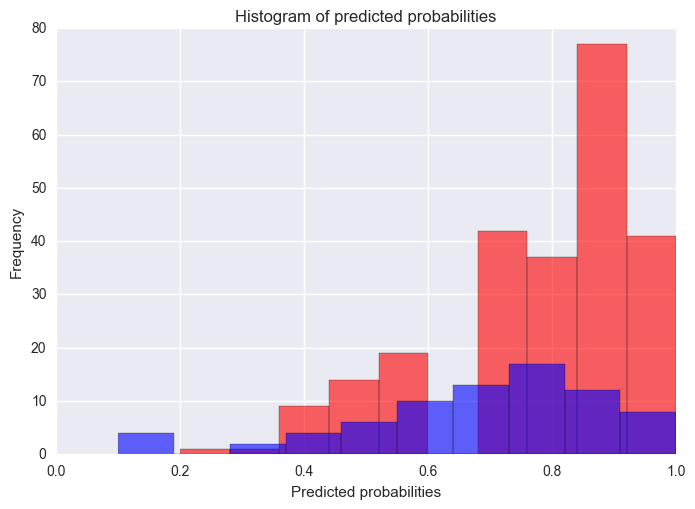

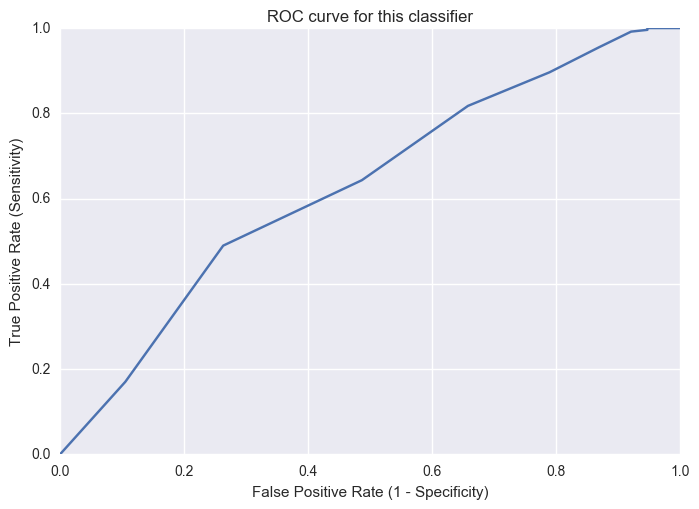

AUC score : 0.666509039851
f1 score : 0.666509039851


In [124]:
from helpers import test_rfc_complete

test_rfc_complete(rfc, x, y)

## Modifying the model

In this part we try to modify our model to have better result.

We have a lot of parameter to test for the random classifier, we selected two of them we think could change the results of the model.

The parameters we will test : 
 - n_estimators
 - max_features

In [125]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [126]:
from scipy.stats import uniform

n_estimators_range = list(range(10,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [127]:
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12314f198>, 'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [128]:
# removed as not relevant even if there are useful informations for us
#rand.cv_results_

In [129]:
rand.best_params_

{'max_features': 0.22199317108973948, 'n_estimators': 25}

In [130]:
rand.best_score_

0.71327821439324934

In [131]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]

Cross validation scores
[ 0.76100629  0.80503145  0.74213836  0.72327044  0.81132075  0.79746835
  0.79113924  0.77848101  0.82278481  0.77070064]
--------------------------
cross mean : 0.780334135026
cross min : 0.723270440252
cross max : 0.822784810127
----------
TN : 19 FP : 57
FN : 10 TP : 231
----------
specificity : 0.25
sensitivity or recall : 0.958506224066
precision : 0.802083333333


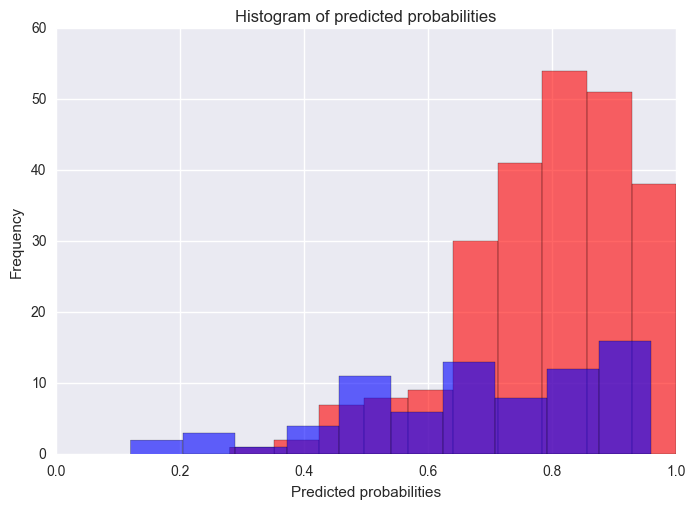

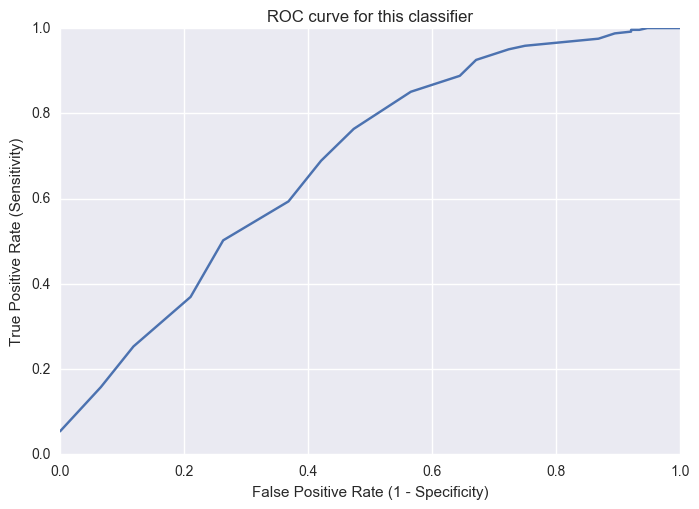

AUC score : 0.704855861373
f1 score : 0.704855861373


In [132]:
test_rfc_complete(RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights), x, y)

We should have with this method the best AUC score we could have. Which is still not really an improvement... (we will reuse this method later)

## Raters changes

As we said earlier in this notebook there are some things we can tune with the raters data we have.

As we know the two raters have the following specificities :
- they rate differently
- they have values [0,0.25,0.5,0.75,1]

There are a few things we want to test : 
- a class for each possible value of the raters
- a class for < 0.5, > 0.5 and 0.5
- an independent learning for both raters
- only keeping the values where rater 1 and 2 are identical

We will test some different mix below

### A cluster for each value with independent raters

Here we will try predicting the 5 possible classes for one of the raters

In [133]:
y_1 = (y_possible['rater1']).values

In [134]:
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_1))
y_1 = le.transform(y_1)
y_1

array([1, 0, 1, ..., 3, 0, 0])

In [135]:
x_train, x_test, y_train, y_test = train_test_split(x, y_1, test_size=0.2, random_state=4)

We use the best parameters we found before (they may need a twist later as the model changes)

In [136]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [137]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.22199317108973948,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [138]:
y_pred = rfc.predict(x_test)

In [139]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.74842767  0.79874214  0.73584906  0.73584906  0.78616352  0.77848101
  0.79113924  0.78481013  0.8164557   0.75159236]
--------------------------
mean : 0.772750987918
min : 0.735849056604
max : 0.816455696203


For this method we decided to not go further as it is difficultly testable and the following method gave kind of similar results

In [140]:
metrics.confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[79, 43,  2,  2,  0],
       [61, 41,  2,  3,  0],
       [25, 15,  0,  2,  0],
       [14,  9,  0,  3,  3],
       [ 8,  2,  1,  1,  1]])

We will not make an emphasis on this but here is the confusion matrix.

### 3 classes for values with a twist on the raters values

Let's look a bit more at the raters :

In [141]:
diff = [x[0] - x[1] for x in zip((y_possible['rater2']).values,(y_possible['rater1']).values) if not x[0] == x[1]]

In [142]:
diff = np.abs(diff)

In [143]:
np.unique(diff, return_counts=True)

(array([ 0.25,  0.5 ]), array([377,   2]))

We can see above that there are only small differences and 2 times where the difference is 0.5

With that we thought of doing this :
- each time both raters are under 0.5 we put it in group 0
- each time both raters are above 0.5 we put it in group 1
- each time one rater is at 0.5 we look if the other falls in 0 or 1 and select that value
- if both rating are 0.5 we put it in group 2
- if both rating are between < 0.5 and > 0.5 we put it in group 3 

In [144]:
y_2 = []
for rate1, rate2 in zip((y_possible['rater2']).values,(y_possible['rater1']).values):
    if ((rate1 <= 0.5 and rate2 < 0.5) or (rate1 < 0.5 and rate2 <= 0.5)):
        y_2.append(1)
    elif ((rate1 >= 0.5 and rate2 > 0.5) or (rate1 > 0.5 and rate2 >= 0.5)):
        y_2.append(0)
    elif (rate1 == 0.5 or rate2 == 0.5):
        y_2.append(2)
    else :
        y_2.append(3)
        

In [145]:
np.unique(y_2, return_counts=True)

(array([0, 1, 2]), array([ 269, 1199,  116]))

We see here that the third group actually is never selected.

In [146]:
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

We use the best parameters we found before.

In [147]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [148]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.79245283  0.80503145  0.73584906  0.76100629  0.79874214  0.75949367
  0.81012658  0.79746835  0.82278481  0.77707006]
--------------------------
mean : 0.786002524242
min : 0.735849056604
max : 0.822784810127


Here accuracy has not changed from before. Let's look at the confusion matrix.

In [149]:
# Prep of training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

# Do prediction for test values
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

# Let's compute the convolution matrix
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
confusion_mx

array([[ 11,  39,   0],
       [  6, 235,   0],
       [  1,  25,   0]])

With the confusion matrix, the first problem we see is that their was **no prediction for the class 2** (there may be a few if you rerun the code). The second is that there is a lot false positive and the actual sensitivity is :

In [150]:
confusion_mx[1,1] / (confusion_mx[0,1]  + confusion_mx[1,1] +confusion_mx[2,1])

0.78595317725752512

Which is worse than what we had before.

### last solution, change the threshold position

The intuition for this change is that we know that our classifier is better at predicting "lighter" players, therefore increasing the considered "light" players we should get better results in terms of accuracy. 

In [151]:
y_3 = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

In [152]:
x_train, x_test, y_train, y_test = train_test_split(x, y_3, test_size=0.2, random_state=4)

We know this is the best result we have, so let's find the best parameters we can.

In [153]:
prop1 = np.sum(y_3) / len(y_3)
prop0 = 1 - prop_1
class_weights = {
    0 : prop0,
    1 : prop1
}

In [154]:
prop1

0.83017676767676762

In [155]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [156]:
from scipy.stats import uniform

n_estimators_range = list(range(20,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [157]:
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(x, y_3)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.83017676767676762},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1288baa58>, 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [158]:
# removed as not relevant even if there are useful informations for us
#rand.cv_results_

In [159]:
rand.best_params_

{'max_features': 0.22199317108973948, 'n_estimators': 35}

In [160]:
rand.best_score_

0.74988534950451358

In [164]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]

In [165]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

Cross validation scores
[ 0.81132075  0.85534591  0.8490566   0.83018868  0.8427673   0.85443038
  0.83544304  0.83544304  0.85443038  0.85350318]
--------------------------
cross mean : 0.842192926544
cross min : 0.811320754717
cross max : 0.85534591195
----------
TN : 9 FP : 41
FN : 8 TP : 259
----------
specificity : 0.18
sensitivity or recall : 0.970037453184
precision : 0.863333333333


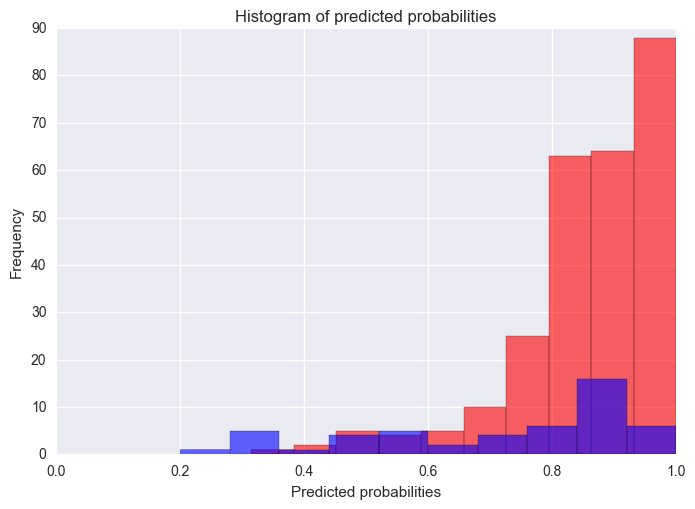

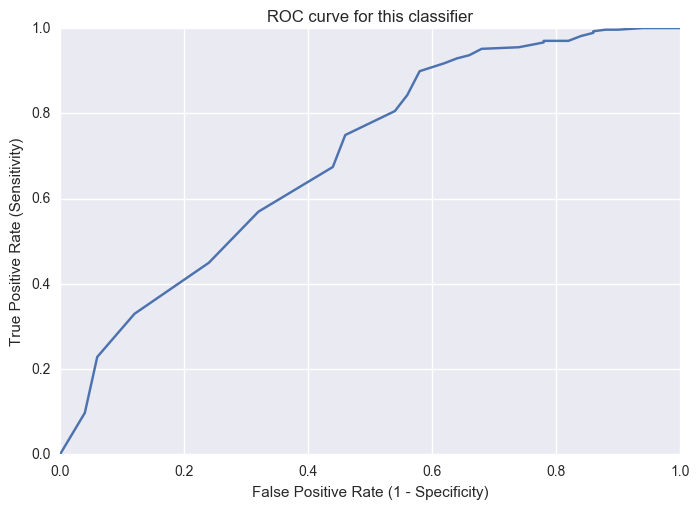

AUC score : 0.739236957558
f1 score : 0.739236957558


In [166]:
test_rfc_complete(rfc, x, y_3)

Ok here we have it, the best result we had so far. The AUC score is higher than ever before (~76%) ! With an accuracy of 84% we are also above all previously done tests. But if we look at specificity, it's not really better than before. but knowing the AUC score we know we can find good compromises between the two. 

## Learning curves

As we were asked let's show the learning curves for our best estimator

In [168]:
y = y_3

In [195]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

In [196]:
from sklearn.model_selection import learning_curve

_, train_scores, test_scores = learning_curve(rfc, x, y, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

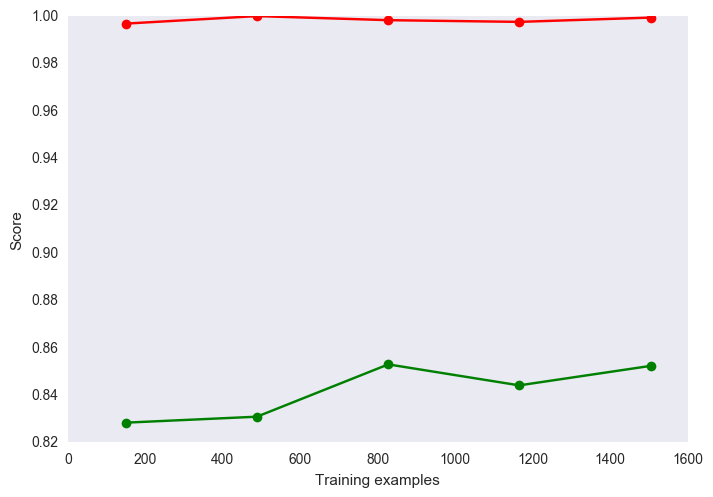

In [197]:
plt.figure()
plt.grid(True)
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

Let's know do the same thing for other parameters :

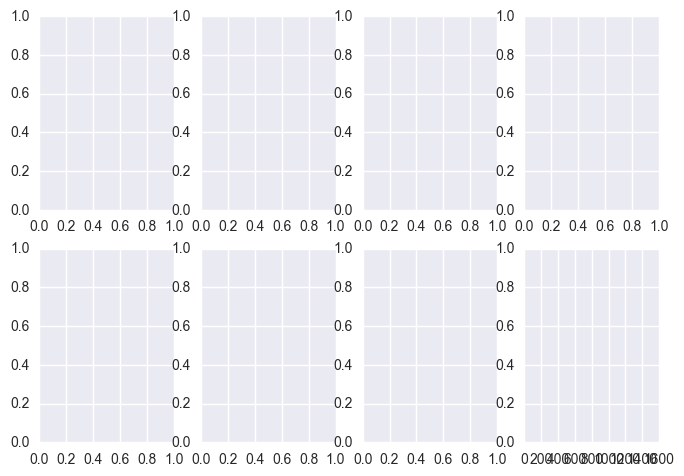

In [217]:
fig, axes = plt.subplots(2,4)

plt.xlim([0,1600])
plt.ylim([0,1])

for i,n_estimators in enumerate(range(1, 40, 5)):
    rfc = RFC(max_features=max_features_b, n_estimators=n_estimators, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    curr_axis = axis[i % 2, i//4]
    
    curr_axis.set_xlabel("Training examples")
    curr_axis.set_ylabel("Score")
    curr_axis.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    curr_axis.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# Conclusion

Of course The last results we have are still not as good as we had hoped. We think this must come from the fact that we have to little information for this problem.